In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, sys

SCRIPT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
from model.corners import (
    detect_edges, 
    detect_hough_lines,
    filter_lines,
    extend_segment,
    intersect,
    compute_intersections,
    extract_corners_from_points,
    detect_4_corners,
)


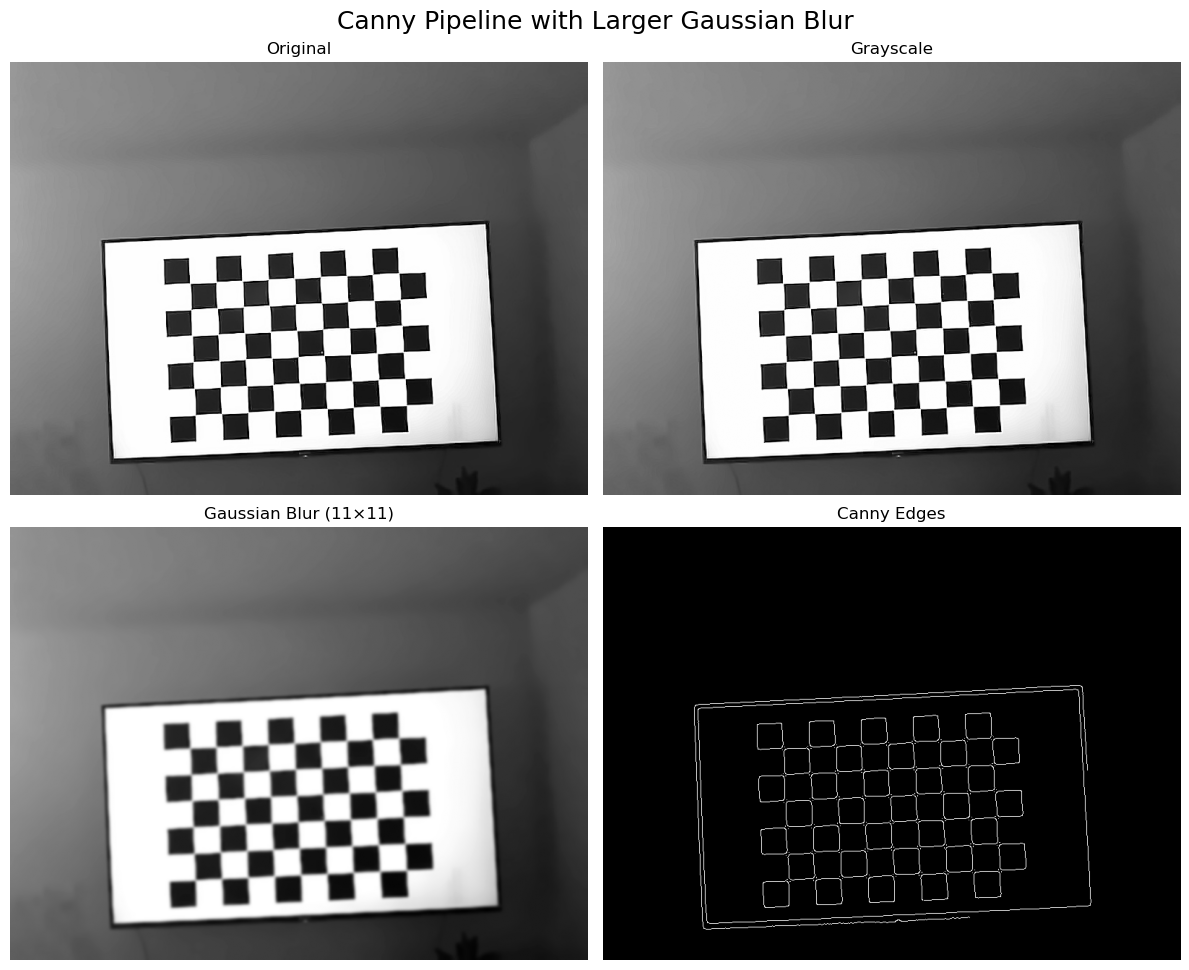

In [2]:


# Load image
img_path = "../data/CALI/cali_bw/calib_29.jpg"
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError("Could not load image at: " + img_path)

# Convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Larger Gaussian Blur (much smoother)
blur = cv2.GaussianBlur(gray, (11,11), 0)   # <-- Larger blur kernel

# Canny edges
edges = cv2.Canny(blur, 40, 100)

# Show all images in one plot
fig, axes = plt.subplots(2, 2, figsize=(12,10))
fig.suptitle("Canny Pipeline with Larger Gaussian Blur", fontsize=18)

axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0,0].set_title("Original")
axes[0,0].axis("off")

axes[0,1].imshow(gray, cmap="gray")
axes[0,1].set_title("Grayscale")
axes[0,1].axis("off")

axes[1,0].imshow(blur, cmap="gray")
axes[1,0].set_title("Gaussian Blur (11×11)")
axes[1,0].axis("off")

axes[1,1].imshow(edges, cmap="gray")
axes[1,1].set_title("Canny Edges")
axes[1,1].axis("off")

plt.tight_layout()
plt.show()


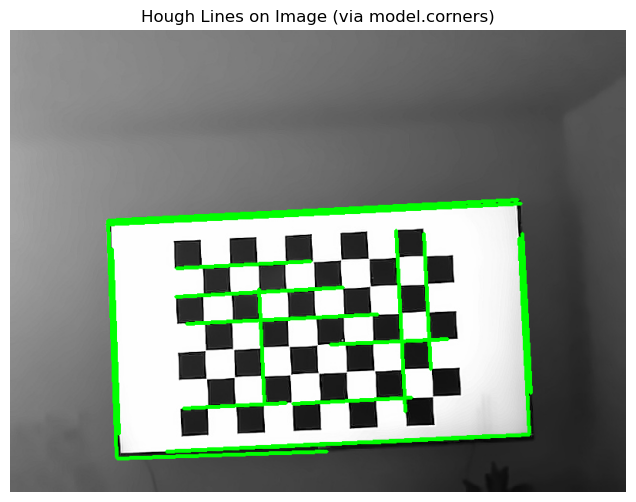

In [3]:
edges = detect_edges(img)
lines = detect_hough_lines(edges, img.shape)
hough_img = img.copy()

for (x1, y1, x2, y2) in lines:
    cv2.line(hough_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

if not lines:
    print("⚠ No lines detected by Hough Transform")

plt.figure(figsize=(8,6))
plt.title("Hough Lines on Image (via model.corners)")
plt.imshow(cv2.cvtColor(hough_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [4]:
edges = detect_edges(img)
lines = detect_hough_lines(edges, img.shape)
vertical, horizontal = filter_lines(lines, img)

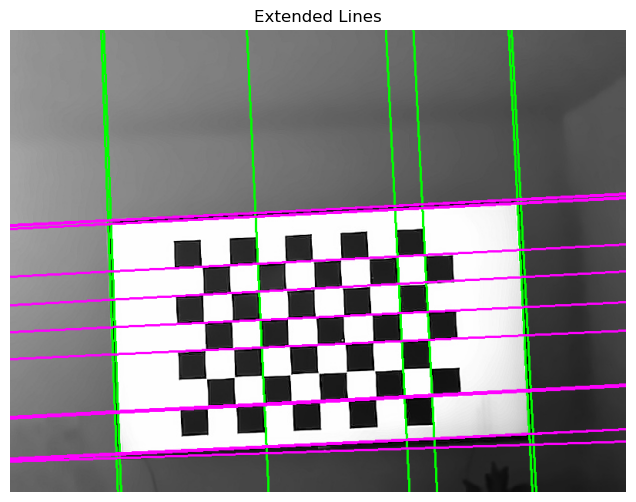

In [5]:
H, W = img.shape[:2]

img2 = img.copy()

for (x1, y1, x2, y2) in horizontal:
    xa, ya, xb, yb = extend_segment(x1, y1, x2, y2, W, H)
    cv2.line(img2, (xa, ya), (xb, yb), (0, 255, 0), 2)

for (x1, y1, x2, y2) in vertical:
    xa, ya, xb, yb = extend_segment(x1, y1, x2, y2, W, H)
    cv2.line(img2, (xa, ya), (xb, yb), (255, 0, 255), 2)

plt.figure(figsize=(8,6))
plt.title("Extended Lines")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [6]:
all_points = []

for hx1,hy1,hx2,hy2 in horizontal:
    for vx1,vy1,vx2,vy2 in vertical:
        p = intersect(hx1,hy1,hx2,hy2, vx1,vy1,vx2,vy2)
        if p is not None:
            all_points.append(p)

print("Raw intersections:", all_points)


Raw intersections: [(130, 251), (130, 246), (130, 247), (142, 551), (142, 550), (130, 251), (137, 420), (134, 350), (142, 555), (141, 549), (133, 313), (135, 385), (139, 496), (139, 495), (127, 251), (126, 247), (126, 247), (137, 551), (137, 550), (127, 251), (133, 421), (130, 350), (138, 556), (137, 550), (129, 313), (131, 385), (135, 497), (135, 495), (658, 225), (658, 220), (658, 220), (674, 524), (674, 524), (658, 224), (667, 396), (663, 321), (674, 538), (674, 524), (661, 285), (665, 359), (671, 469), (671, 467), (662, 225), (662, 220), (662, 219), (678, 524), (678, 524), (662, 224), (672, 396), (668, 320), (679, 538), (678, 524), (666, 285), (670, 359), (675, 468), (675, 467), (499, 233), (499, 228), (499, 228), (514, 532), (514, 532), (499, 232), (508, 403), (504, 329), (515, 543), (514, 532), (502, 294), (506, 367), (512, 477), (512, 475), (535, 231), (535, 226), (535, 226), (550, 531), (550, 530), (535, 230), (544, 402), (540, 328), (551, 542), (550, 530), (538, 292), (542, 36

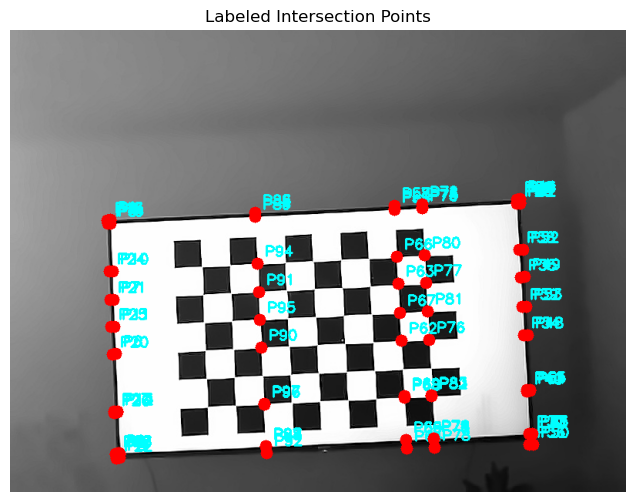

In [7]:
img_points = img.copy()

for i, (x, y) in enumerate(all_points):
    xi = int(x)
    yi = int(y)

    # Ensure point is inside image
    if 0 <= xi < img.shape[1] and 0 <= yi < img.shape[0]:
        cv2.circle(img_points, (xi, yi), 8, (0, 0, 255), -1)
        cv2.putText(
            img_points,
            f"P{i}",
            (xi + 10, yi - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 0),
            2
        )

# Display using Matplotlib
plt.figure(figsize=(8, 6))
plt.title("Labeled Intersection Points")
plt.imshow(cv2.cvtColor(img_points, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [8]:
corners = extract_corners_from_points(all_points)

if corners is None:
    print("⚠ No valid corners found")
else:
    TL, TR, BR, BL = corners
    print("Top-Left:     ", TL)
    print("Top-Right:    ", TR)
    print("Bottom-Right: ", BR)
    print("Bottom-Left:  ", BL)
    print("Corners:", corners)


Top-Left:      (126.0, 247.0)
Top-Right:     (662.0, 219.0)
Bottom-Right:  (679.0, 538.0)
Bottom-Left:   (138.0, 556.0)
Corners: [(126.0, 247.0), (662.0, 219.0), (679.0, 538.0), (138.0, 556.0)]


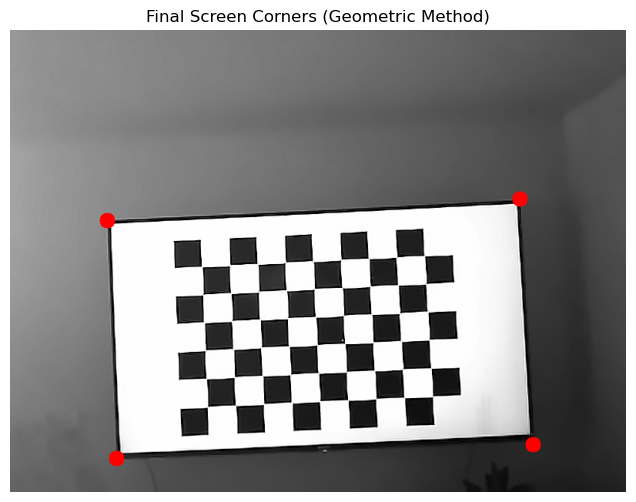

In [9]:
img_corners = img.copy()

for (x, y) in corners:
    cv2.circle(img_corners, (int(x), int(y)), 10, (0, 0, 255), -1)

plt.figure(figsize=(8,6))
plt.title("Final Screen Corners (Geometric Method)")
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [10]:
def extract_patch(img, point, size=50):
    x, y = map(int, point)
    r = size // 2

    return img[max(0,y-r):min(img.shape[0],y+r),
               max(0,x-r):min(img.shape[1],x+r)]

PATCH = 50

TL, TR, BR, BL = corners

TL_roi = extract_patch(img, TL, PATCH)
TR_roi = extract_patch(img, TR, PATCH)
BR_roi = extract_patch(img, BR, PATCH)
BL_roi = extract_patch(img, BL, PATCH)


In [11]:
def zoom(img, scale=3):
    return cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)

TL_zoom = zoom(TL_roi)
TR_zoom = zoom(TR_roi)
BR_zoom = zoom(BR_roi)
BL_zoom = zoom(BL_roi)


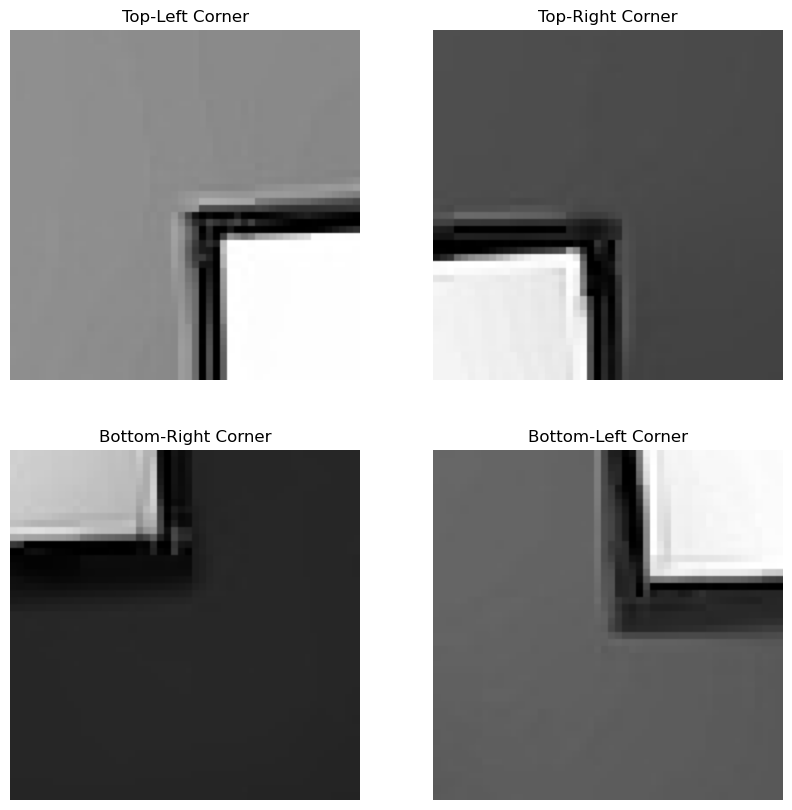

In [12]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Top-Left Corner")
plt.imshow(cv2.cvtColor(TL_zoom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2,2,2)
plt.title("Top-Right Corner")
plt.imshow(cv2.cvtColor(TR_zoom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2,2,3)
plt.title("Bottom-Right Corner")
plt.imshow(cv2.cvtColor(BR_zoom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2,2,4)
plt.title("Bottom-Left Corner")
plt.imshow(cv2.cvtColor(BL_zoom, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


In [13]:
sift = cv2.SIFT_create()

def describe_patch(patch):
    kp, des = sift.detectAndCompute(patch, None)
    return kp, des

kp_TL, des_TL = describe_patch(TL_roi)
kp_TR, des_TR = describe_patch(TR_roi)
kp_BR, des_BR = describe_patch(BR_roi)
kp_BL, des_BL = describe_patch(BL_roi)


In [14]:
# =========================================
# Load next frame
# =========================================
img2 = cv2.imread("../data/CALI/cali_bw/calib_11.jpg")
if img2 is None:
    raise ValueError("Image not found: calib_11.jpg")

new_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Extract SIFT from new frame
kp_new, des_new = sift.detectAndCompute(new_gray, None)

if des_new is None:
    raise ValueError("No SIFT descriptors found in new image!")

# Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)


# =========================================
# Corner-matching function (FIXED)
# =========================================
def match_corner(patch_img, kp_patch, des_patch, corner_name):
    if patch_img is None or patch_img.size == 0:
        print(f"[{corner_name}] ERROR: patch_img is empty")
        return None, None

    if des_patch is None:
        print(f"[{corner_name}] ERROR: no descriptors in patch")
        return None, None

    # KNN match
    matches = bf.knnMatch(des_patch, des_new, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good) == 0:
        print(f"[{corner_name}] No good matches found")
        return None, None

    # Collect new-frame points
    pts_new = np.float32([kp_new[m.trainIdx].pt for m in good])

    # Use median for stability
    cx, cy = np.median(pts_new, axis=0)

    # Visualization
    vis = cv2.drawMatches(
        patch_img, kp_patch,
        new_gray, kp_new,
        sorted(good, key=lambda m: m.distance)[:20],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(10,5))
    plt.title(f"SIFT matches for {corner_name}")
    plt.imshow(vis, cmap='gray')
    plt.axis("off")

    return (float(cx), float(cy)), vis


# =========================================
# MATCH ALL FOUR CORNERS
# =========================================
TL2, vis_TL = match_corner(TL_patch, kp_TL, des_TL, "TL")
TR2, vis_TR = match_corner(TR_patch, kp_TR, des_TR, "TR")
BR2, vis_BR = match_corner(BR_patch, kp_BR, des_BR, "BR")
BL2, vis_BL = match_corner(BL_patch, kp_BL, des_BL, "BL")

plt.show()


NameError: name 'TL_patch' is not defined